In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
import collections

In [3]:
#=========================================#
#         MODEL/TRAINING OPTIONS
#=========================================#

# Network Architecture: ['LeNet', 'ResNet18', 'ResNet34']
net_model = 'ResNet18'

# Augment Train Dataset with transforms: [True, False]
augment_dataset = False

# Number of gpus
n_gpu = 2

# Use Nvidia Apex for Auto Mixed Precision (AMP) on Tensorcores
use_amp = False

# Mixed-precision Operation Level
opt_level = 'O1'

#=========================================#
#             DIRECTORIES
#=========================================#
# Set Directory for dataset
DATA_DIR = './data/cifar-10/'
# Set Directory for checkpoints and results
if augment_dataset:
    CHECKPOINT_DIR = './checkpoints/' + net_model + '_augm/'
    RESULT_DIR = './results/' + net_model + '_augm/'
else:
    CHECKPOINT_DIR = './checkpoints/' + net_model + '/'
    RESULT_DIR = './results/' + net_model + '/'


# Set Device to train on CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

# Initialize NVIDIA AMP for Tensorcore training
if use_amp:
    try:
        from apex import amp, optimizers
        from apex.parallel import DistributedDataParallel as DDP
        from apex.fp16_utils import *
        print('Using NVIDIA Automatic Mixed Precision (AMP)')
    except ImportError:
        raise ImportError("Apex not installed")

device: cuda:0


In [4]:
def AddGaussNoise(x):
    #prob_noise = random.random()
    #if prob_noise >= 0.75:
        ## add random noise to the input images
        x = x + 0.05 * torch.randn(*x.shape)
        # Clip the images to be between 0 and 1
        x = np.clip(x, 0., 1.)
        return x

In [5]:
#==================================#
#         DATASET OPTIONS 
#==================================#
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2

# Define Transformations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_augm = transforms.Compose([transforms.RandomHorizontalFlip(),                                 # randomly flip
                                     transforms.RandomAffine(degrees=10,translate=(.05,.05)),           # randomly rotate and translate
                                     transforms.CenterCrop((26,26)),                                    # crop to remove black sections
                                     transforms.Pad(padding=(3,3,3,3), padding_mode='symmetric'),       # pad with reflections
                                     transforms.ToTensor(),
                                     transforms.RandomApply([transforms.Lambda(AddGaussNoise)],p=0.25), # Add Gaussian Noise to ~1/4 images
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Determines whether trainset will be augmented with transformations
if augment_dataset:
    transform_train = transform_augm
else:
    transform_train = transform
    
#==================================#
#         LOAD DATASET 
#==================================#
# Import Datasets
trainset = datasets.CIFAR10(root=DATA_DIR, train=True,
                            download=True, transform=transform_train)
validset = datasets.CIFAR10(root=DATA_DIR, train=True,
                            download=True, transform=transform)
testset = datasets.CIFAR10(root=DATA_DIR, train=False,
                            download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Define DataLoader for Train/Validation/Test sets
trainloader = DataLoader(trainset, batch_size=batch_size,
                         sampler=train_sampler, num_workers=num_workers)
validloader = DataLoader(validset, batch_size=batch_size,
                         sampler=valid_sampler, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)

# Define Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


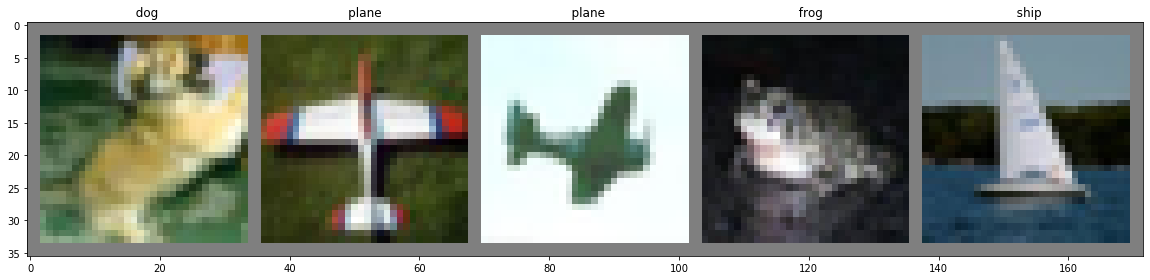

  dog 			 plane 			 plane 			  frog 			  ship


In [8]:
# Display some training images
def imshow(img, save_dir=''):
    img = img / 2 + 0.5     #unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title('                                                 '.join(
        '%5s' % classes[labels[j]] for j in range(5)))
    if save_dir!='':
        plt.savefig(save_dir)
    plt.show()

# Get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images[:5]), save_dir=RESULT_DIR+'input/input.png')
# Print labels
print(' \t\t\t '.join('%5s' % classes[labels[j]] for j in range(5)))

In [9]:
#############################
## Define CNN Architecture ##
#############################
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#ResNet = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=False)
#ResNet = torchvision.models.resnet18(pretrained=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

if net_model == 'LeNet':
    print('NETWORK MODEL:'); print(LeNet()); print()
elif net_model == 'ResNet18':
    print('NETWORK MODEL:'); print(ResNet18()); print()
elif net_model == 'ResNet34':
    print('NETWORK MODEL:'); print(ResNet34()); print()
else:
    print(net_model, 'IS NOT AN AVAILABLE NETWORK')

NETWORK MODEL:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, moment

In [10]:
def model_init(load_type='train', checkpoint_type='validate', checkpoint=-1, lr=0, sched_gamma=0.9, sched_step=10):
    learning_rate = lr
    sched_gamma = sched_gamma
    sched_step = sched_step
    
    # Initialize model
    if net_model == 'LeNet':
        model = LeNet()
    elif net_model == 'ResNet18':
        model = ResNet18()
    elif net_model == 'ResNet34':
        model = ResNet34()
    # Send model to GPU
    model = model.to(device)
    
    if load_type=='train' or load_type=='restart':
        # Initialize Loss Function    
        criterion = nn.CrossEntropyLoss()
        # Initialize SGD Optimizer
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        # Initialize Learning Rate Scheduler
        #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sched_step, gamma=sched_gamma, last_epoch=-1)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
        # Amp Initialization
        if use_amp:
            model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

    # Split model between GPUs
    if n_gpu > 1:
        model = nn.DataParallel(model, list(range(n_gpu)))

    ##############################
    ## LOAD PREVIOUS CHECKPOINT ##
    ##############################
    # Define directory to save and load checkpoints
    LOAD_DIR = CHECKPOINT_DIR + checkpoint_type + '/'
    print('Loading checkpoints from directory:', LOAD_DIR)
    if load_type == 'restart':
        checkpoints = []
    else:
        # Read in available checkpoints and sort 
        checkpoints = sorted([f for f in os.listdir(LOAD_DIR) if os.path.isfile(LOAD_DIR + f)])
        print(); print('CHECKPOINTS AVAILABLE:'); print(checkpoints)
    
    # If no checkpoints available
    if len(checkpoints) == 0:
        print('Last Checkpoint: [None]')
        # Start from first epoch
        last_epoch = 0
        loss_min = np.Inf
    # Else if checkpoints available
    else:
        # Load latest checkpoint
        if checkpoint == -1:
            load_checkpoint = checkpoints[-1]
        # Load specified checkpoint
        else:
            load_checkpoint = 'cifar_net_' + checkpoint + '.pt'
        print('Loading Checkpoint:', load_checkpoint)
        
        
        # Load latest checkpoint
        latest_checkpoint = torch.load(LOAD_DIR + load_checkpoint)

        # Load model state to resume training
        model.load_state_dict(latest_checkpoint['net'])
        
        if load_type=='train':
            model.train()
            # Load Optimizer, Scheduler, and Amp State
            optimizer.load_state_dict(latest_checkpoint['optimizer'])
            scheduler.load_state_dict(latest_checkpoint['scheduler'])
            #if use_amp:
                #amp.load_state_dict(latest_checkpoint['amp'])
           
            loss_min = latest_checkpoint['loss']
            
                

            # Reassign Scheduler gamma if desired.
            #scheduler.gamma = sched_gamma
            #scheduler.step_size = sched_step
            scheduler.patience=2
            if lr != 0:
                optimizer.param_groups[0]['lr'] = lr
            
            # Use checkpoint number as last epoch
            last_epoch = scheduler.last_epoch
            print('Last Epoch:', last_epoch); print()
        else:
            model.eval()
        
        
    
    
    print('MODEL STATE_DICT:', net_model)
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print()
    if load_type=='train' or load_type=='restart':
        print('OPTIMIZER STATE_DICT:')
        for var_name in optimizer.state_dict():
            if var_name != 'state':
                print(var_name, "\t", optimizer.state_dict()[var_name])
        print(); print('SCHEDULER STATE_DICT:')
        for var_name in scheduler.state_dict():
            print(var_name, "\t", scheduler.state_dict()[var_name])
        print('Learning Rate:', optimizer.param_groups[0]['lr'])#scheduler.get_lr())
        print('Last Validation Loss Min:', loss_min); print()
        
        return model, criterion, optimizer, scheduler, last_epoch, loss_min
    else:
        return model

In [84]:
model, criterion, optimizer, scheduler, last_epoch, loss_min = model_init(load_type='train', checkpoint_type='validate', lr=5e-7, sched_gamma=0.9, sched_step=5)
#scheduler.last_epoch=11
#######################
## Train the Network ##
#######################
# Define Number of Epochs to train
n_epochs = 5
if scheduler.last_epoch == 0:
    valid_loss_min = np.Inf # track change in validation loss
else:
    valid_loss_min = loss_min

for epoch in range(last_epoch, last_epoch+n_epochs):
    #print('EPOCH:', epoch+1, '\t LR:', scheduler.get_lr())
    # Save start times
    ep_start = time.time()
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    running_loss = 0.0
    ######################    
    # Train the model #
    ######################
    # For each batch
    for i, data in enumerate(trainloader, 0):
        iter_start = time.time()
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data[0], data[1]
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        
        if use_amp:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        optimizer.step()
        
        # Print Statistics
        train_loss += loss.item()*inputs.size(0)
        running_loss += loss.item()
        if i % 100 == 99:
            iter_time = time.time() - iter_start
            #print('[%d, %5d] loss: %.3f, TIME: %.3f seconds' %
            #      (epoch + 1, i + 1, running_loss / 100, iter_time))
            running_loss = 0.0
    ######################    
    # validate the model #
    ######################
    model.eval()
    for i, data in enumerate(validloader):
        # move tensors to GPU if CUDA is available
        inputs, labels = data[0].to(device), data[1].to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # update average validation loss 
        valid_loss += loss.item()*inputs.size(0)
    
    # Mark epoch time
    ep_time = time.time() - ep_start
    
    # calculate average epoch losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    current_lr = optimizer.param_groups[0]['lr']
    # print training/validation statistics 
    print('Epoch: {} \t Learning Rate: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTIME: {:.3f}'.format(
        epoch+1, current_lr, train_loss, valid_loss, ep_time))
    # Step Learning Rate Scheduler
    scheduler.step(valid_loss)
    
    #print('END EPOCH:', epoch+1, 'TIME:', ep_time, 'seconds'); print()
    
    # Save checkpoint every 5 epochs
    if use_amp:
            amp_state = amp.state_dict()
    else:
            amp_state = None        
    if (epoch+1) % 5 == 0:
        PATH = CHECKPOINT_DIR+'train/train_LeNet_' + str(epoch+1) + '.pt'
        current_state = {'net': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'amp': amp_state,
                         'loss': valid_loss}
        torch.save(current_state, PATH)
        #print('Checkpoint for Epoch', epoch+1, 'saved in', PATH)
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        VALID_PATH = CHECKPOINT_DIR+'validate/valid_' + net_model + '_' + str(epoch+1) + '.pt'
        current_state = {'net': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'amp': amp_state,
                         'loss': valid_loss}
        torch.save(current_state, VALID_PATH)
        valid_loss_min = valid_loss
    if epoch>12 and valid_loss > 1.0: print('Model has begun Overfitting. Exiting training...'); break; 
print('Finished Training')

Loading checkpoints from directory: ./checkpoints/ResNet18/validate/

CHECKPOINTS AVAILABLE:
['valid_ResNet18_10.pt', 'valid_ResNet18_11.pt', 'valid_ResNet18_13.pt']
Loading Checkpoint: valid_ResNet18_13.pt
Last Epoch: 13

MODEL STATE_DICT: ResNet18
module.conv1.weight 	 torch.Size([64, 3, 3, 3])
module.bn1.weight 	 torch.Size([64])
module.bn1.bias 	 torch.Size([64])
module.bn1.running_mean 	 torch.Size([64])
module.bn1.running_var 	 torch.Size([64])
module.bn1.num_batches_tracked 	 torch.Size([])
module.layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
module.layer1.0.bn1.weight 	 torch.Size([64])
module.layer1.0.bn1.bias 	 torch.Size([64])
module.layer1.0.bn1.running_mean 	 torch.Size([64])
module.layer1.0.bn1.running_var 	 torch.Size([64])
module.layer1.0.bn1.num_batches_tracked 	 torch.Size([])
module.layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
module.layer1.0.bn2.weight 	 torch.Size([64])
module.layer1.0.bn2.bias 	 torch.Size([64])
module.layer1.0.bn2.running_mean 	 torch.

Loading checkpoints from directory: ./checkpoints/ResNet18/validate/

CHECKPOINTS AVAILABLE:
['valid_ResNet18_10.pt', 'valid_ResNet18_11.pt', 'valid_ResNet18_13.pt']
Loading Checkpoint: valid_ResNet18_13.pt
MODEL STATE_DICT: ResNet18
module.conv1.weight 	 torch.Size([64, 3, 3, 3])
module.bn1.weight 	 torch.Size([64])
module.bn1.bias 	 torch.Size([64])
module.bn1.running_mean 	 torch.Size([64])
module.bn1.running_var 	 torch.Size([64])
module.bn1.num_batches_tracked 	 torch.Size([])
module.layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
module.layer1.0.bn1.weight 	 torch.Size([64])
module.layer1.0.bn1.bias 	 torch.Size([64])
module.layer1.0.bn1.running_mean 	 torch.Size([64])
module.layer1.0.bn1.running_var 	 torch.Size([64])
module.layer1.0.bn1.num_batches_tracked 	 torch.Size([])
module.layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
module.layer1.0.bn2.weight 	 torch.Size([64])
module.layer1.0.bn2.bias 	 torch.Size([64])
module.layer1.0.bn2.running_mean 	 torch.Size([64])
modul

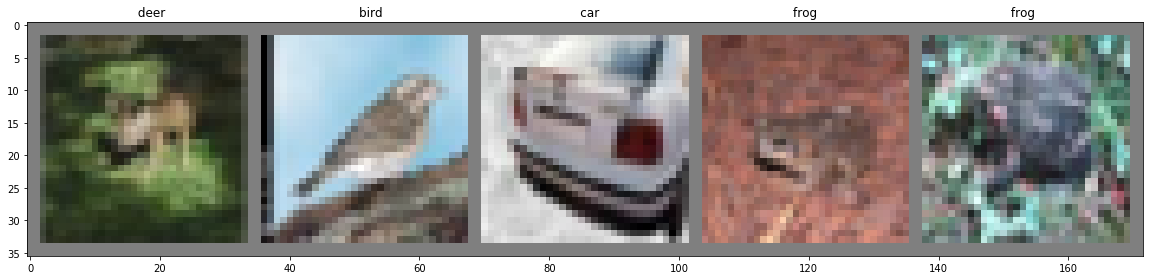

GroundTruth: 	  deer 	  bird 	   car 	  frog 	  frog
Predicted: 	  frog 	  bird 	  ship 	  frog 	  frog

Accuracy of the network on the 10000 test images: 80 %

Accuracy of plane : 81 %
Accuracy of   car : 95 %
Accuracy of  bird : 67 %
Accuracy of   cat : 50 %
Accuracy of  deer : 79 %
Accuracy of   dog : 82 %
Accuracy of  frog : 79 %
Accuracy of horse : 84 %
Accuracy of  ship : 100 %
Accuracy of truck : 84 %


In [11]:
model = model_init(load_type='validate', checkpoint_type='validate', checkpoint=-1)
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print Images
imshow(torchvision.utils.make_grid(images[:5]), save_dir=RESULT_DIR+'test/test.png')
print('GroundTruth:', ' '.join('\t %5s' % classes[labels[j]] for j in range(5)))

images, labels = images.to(device), labels.to(device)
outputs = model(images)

_, predicted = torch.max(outputs[:5], 1)
print('Predicted:', ' '.join('\t %5s' % classes[predicted[j]] for j in range(5)))

correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total)); print()
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [83]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total)); print()
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 80 %

Accuracy of plane : 78 %
Accuracy of   car : 89 %
Accuracy of  bird : 79 %
Accuracy of   cat : 78 %
Accuracy of  deer : 71 %
Accuracy of   dog : 51 %
Accuracy of  frog : 87 %
Accuracy of horse : 93 %
Accuracy of  ship : 87 %
Accuracy of truck : 90 %
